# Seminar 9 - Model Selection & Regularization

The task is to predict the fat content of a meat sample on the basis of its NIR absorbance spectrum. In real applications, the analysis of NIR-spectra is challenging and there is a wide range of analysis strategies.1 They typically involve principle component analysis (PCA) or make use of neural networks to infer chemical information (like fat content) from NIR-spectra. Here in this assignment it will do to apply multiple linear models with possibly some shrinkage involved.

- Read in the data with the command readRDS and store the dataframe under the name nirData.
- The data is formatted in «wide format». This means that each measurement has its own column: Check that you have indeed in total data of 215 meat samples with each a fat measurement (column fat) and 100 NIR-variables.
- From the full data set, set aside a subset of 25% of all observations as test data set and use the remaining 75% as training data. We explain below why we will not use here a separate validation data set.

In [13]:
data = readRDS("data/NIR_meat.rds")
head(data)

,fat,NIR1,NIR2,NIR3,NIR4,NIR5,NIR6,NIR7,NIR8,NIR9,⋯,NIR91,NIR92,NIR93,NIR94,NIR95,NIR96,NIR97,NIR98,NIR99,NIR100
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,22.5,2.624678,2.617141,2.661152,2.632626,2.600933,2.640948,2.612343,2.615394,2.636674,⋯,3.003346,2.993943,2.957721,2.930983,2.917586,2.902895,2.878649,2.860067,2.816934,2.814325
2,40.1,2.831254,2.824333,2.852733,2.834804,2.875328,2.856527,2.871460,2.863564,2.863543,⋯,3.302150,3.321843,3.286252,3.255096,3.258644,3.242529,3.230499,3.214022,3.189640,3.125834
3,8.4,2.574347,2.604083,2.591397,2.590455,2.584382,2.580690,2.599903,2.588648,2.599094,⋯,2.709575,2.686483,2.676513,2.652291,2.613180,2.618521,2.572596,2.590596,2.558228,2.528773
4,5.9,2.808672,2.841908,2.838851,2.820005,2.823712,2.821007,2.849189,2.846039,2.839051,⋯,3.004082,2.977812,2.974285,2.916183,2.908807,2.874201,2.844503,2.863643,2.827721,2.795507
5,25.5,2.789264,2.791681,2.788367,2.790700,2.807376,2.787763,2.801650,2.815338,2.809073,⋯,3.312566,3.307170,3.300364,3.253781,3.245728,3.212378,3.196019,3.181573,3.152868,3.134712
6,42.7,3.015988,3.001191,3.029782,3.052708,3.034373,3.029786,3.047315,3.043427,3.061366,⋯,3.582822,3.562521,3.570639,3.533749,3.524914,3.534874,3.499294,3.484862,3.467219,3.446953


In [97]:
# Test Train Split
set.seed(2023)
i <- sample(x=nrow(data), size = NROW(data)/4)
test <- dplyr::slice(data, i)
train <- dplyr::slice(data, -i)

## Visualizing

Visualize and describe the univariate sample distribution of fat content (column fat): what is the mean and the median fat content in the sample?

[1] 17.5284

[1] 12.6

[1] 155.029

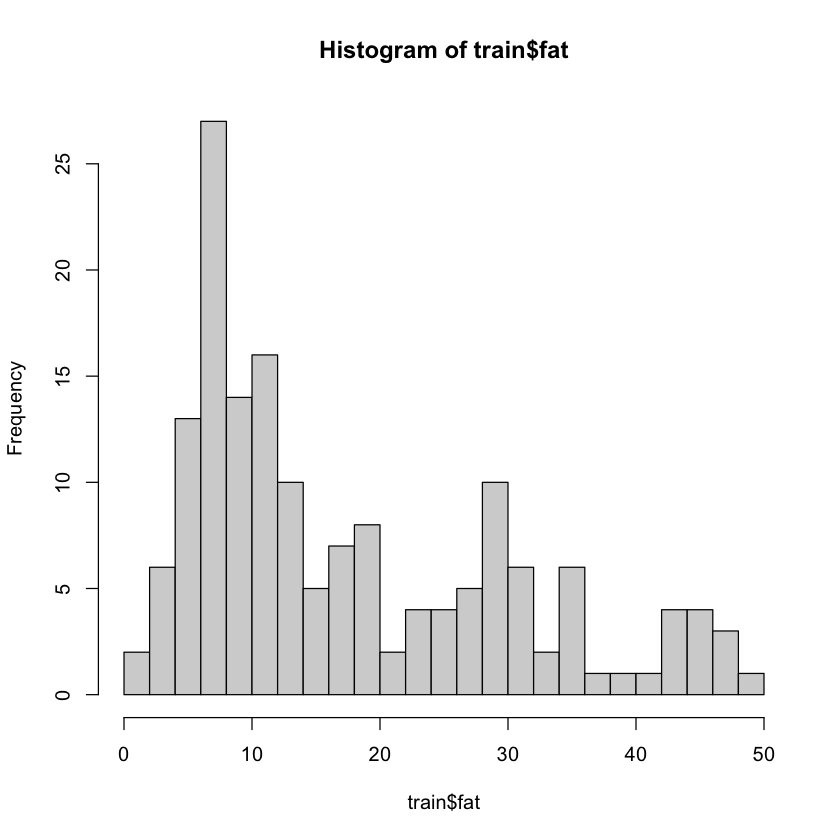

In [98]:
hist(train$fat, breaks=30)
mean(train$fat)
median(train$fat)
var(train$fat)

Each NIR-predictors (aka NIR-features) has its own variance. Across the features, what is the range of these variances? What is the mean variance?

In [99]:
vars <- c()
for (col in train[-1]) {
    vars <- c(vars, var(col))
}
max(vars)
min(vars)
mean(vars)

[1] 0.2756873

[1] 0.1541036

[1] 0.2430984

Look at the correlations among the NIR-features themselves and also the correlation with the response variable fat. Try to get an overview, for instance, by considering only — say — every 10th feature. What stands out?

## Linear Model
Fit an additive model with intercept and all available NIR-predictors on the training data and store the model fit. We will use this model as a reference in our benchmark of different models.

In [100]:
m.lm <- lm(fat ~ ., data = train)

In [102]:
summary(m.lm)


Call:
lm(formula = fat ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.1045 -1.2343  0.2291  1.1686  5.1911 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  20.0424     5.5543   3.608 0.000623 ***
NIR1         10.0683    30.3434   0.332 0.741169    
NIR2         25.4289    24.6740   1.031 0.306799    
NIR3        -35.9336    27.8005  -1.293 0.201041    
NIR4         19.0628    31.3012   0.609 0.544779    
NIR5        -37.2157    30.0092  -1.240 0.219673    
NIR6        -29.4103    26.9023  -1.093 0.278594    
NIR7         24.3261    30.6364   0.794 0.430258    
NIR8         10.6327    24.3081   0.437 0.663355    
NIR9         54.4140    27.6789   1.966 0.053866 .  
NIR10        14.1811    35.1660   0.403 0.688165    
NIR11       -41.0173    33.4085  -1.228 0.224257    
NIR12        20.1472    33.1033   0.609 0.545039    
NIR13       -33.3652    28.5899  -1.167 0.247741    
NIR14       -52.1544    28.8415  -1.808 0.075488 .  


## Variable Selection
All absorbance predictors are potentially relevant predictors for fat-level and hence the full linear model seems like the best linear additive model. Nevertheless, we try out two variable selection methods to build two simpler regression models.

### Using AIC
The R-function step uses — starting from the provided model fit — the AIC-criterion to decide if dropping or adding a variable improves the model. The AIC-criterion balances model fit on the training data with model complexity. Lower values of AIC indicate better fits. For a fitted model with p parameters, AIC is defined as 

$AIC = −2 × max(loglikelihood) + 2 × p$

In [149]:
m.aic <- step(m.lm, direction = "both", k = 2, trace = 0)

In [150]:
# 53 predictors left
m.aic


Call:
lm(formula = fat ~ NIR2 + NIR3 + NIR4 + NIR5 + NIR7 + NIR9 + 
    NIR11 + NIR13 + NIR14 + NIR15 + NIR18 + NIR19 + NIR20 + NIR21 + 
    NIR26 + NIR29 + NIR30 + NIR31 + NIR32 + NIR33 + NIR36 + NIR38 + 
    NIR40 + NIR42 + NIR43 + NIR44 + NIR45 + NIR47 + NIR48 + NIR50 + 
    NIR51 + NIR53 + NIR54 + NIR55 + NIR57 + NIR59 + NIR63 + NIR66 + 
    NIR67 + NIR69 + NIR70 + NIR72 + NIR74 + NIR75 + NIR78 + NIR79 + 
    NIR80 + NIR84 + NIR89 + NIR92 + NIR94 + NIR97 + NIR98, data = train)

Coefficients:
(Intercept)         NIR2         NIR3         NIR4         NIR5         NIR7  
      21.47        29.07       -25.27        35.22       -42.61        29.40  
       NIR9        NIR11        NIR13        NIR14        NIR15        NIR18  
      45.74       -27.20       -50.51       -52.74        34.12        34.73  
      NIR19        NIR20        NIR21        NIR26        NIR29        NIR30  
      20.33        20.99       -47.67       -43.95       -64.00       -44.66  
      NIR31        NIR32

### Using BIC
Use the parameter $k$ of the step-function to adjust the penalization factor to get BIC instead of AIC as variable selection criterion. Confirm that the resulting model is sparser than the model selected by AIC.
How many predictors in the BIC-model are statistically significant at the significance level of 5%?

In [151]:
m.bic <- step(m.lm, direction = "both", k = log(length(train)), trace = 0)

In [152]:
m.bic


Call:
lm(formula = fat ~ NIR4 + NIR13 + NIR21 + NIR26 + NIR29 + NIR30 + 
    NIR40 + NIR42 + NIR45 + NIR50 + NIR74 + NIR92 + NIR38, data = train)

Coefficients:
(Intercept)         NIR4        NIR13        NIR21        NIR26        NIR29  
      23.64        66.86       -47.55       -43.28       -41.45       -54.20  
      NIR30        NIR40        NIR42        NIR45        NIR50        NIR74  
     -36.55        38.89        72.29        66.70       -48.80       -48.72  
      NIR92        NIR38  
      31.94        41.92  


## Shrinkage Methods
Variable selection either keeps a variable or drops it completely from the model, — it is either-or. The R-package `glmnet` allows for different ways to continuously shrink parameter coefficient estimates of a linear regression model. The main functions of the package are `glmnet` and `cv.glmnet`.

Within these functions the parameter alpha= specifies the type of continuous penalization:

- `alpha=0` corresponds to ridge regression.
- `alpha=1` is Lasso-regression.
- a value between 0 and 1 corresponds to a mixture of ridge and Lasso-regression and this approach to penalization is called elastic net.

In [153]:
library("glmnet")
library("dplyr")

y_glm_train <- train |> dplyr::pull(fat)
x_glm_train <- train |> dplyr::select(!fat) |> as.matrix()
y_glm_test <- test |> dplyr::pull(fat)
x_glm_test <- test |> dplyr::select(!fat) |> as.matrix()

Concretely, fit three different models in the following order:
- Ridge regression
- Lasso-regression
- Elastic net as mixture of ridge and Lasso-regression, with mixing parameter $α$ = 0.3. (With $α$ = 0.3, we choose a stronger contribution of ridge regression because we have so strongly correlated predictors where ridge regression is designed for.)

In [182]:
m.glm_ridge <- cv.glmnet(x_glm_train, y_glm_train, alpha = 0)
m.glm_lasso <- cv.glmnet(x_glm_train, y_glm_train, alpha = 1)
m.glm_elastic <- cv.glmnet(x_glm_train, y_glm_train, alpha = 0.3)

Identify for each of the three models classes the value for the penalization parameter $λ$ so that the cross-validated prediction error is within one standard error of the minimum prediction error.

How are the model coefficients affected by the penalization? Compare the estimated coefficients with those from the full linear model.

## Model Assessment
We have fitted different models on the NIR-training data. Now, we want to use the reserved test data to assess these models.

In [155]:
residual <- function(predictions, actual) sum((predictions - actual)^2)

In [166]:
residual(predict(m.glm_elastic, newx = x_glm_test), y_glm_test)

[1] 615.0855

In [167]:
residual(predict(m.glm_lasso, newx = x_glm_test), y_glm_test)

[1] 621.549

In [168]:
residual(predict.lm(m.bic, newdata = test), test$fat)

[1] 777.1311

In [169]:
residual(predict.lm(m.aic, newdata = test), test$fat)

[1] 1324.121

In [170]:
residual(predict(m.glm_ridge, newx = x_glm_test), y_glm_test)

[1] 1352.55

In [171]:
residual(predict.lm(m.lm, newdata = test), test$fat)

[1] 1647.876

### Ranking
1. Elastic with $\alpha = 0.3$
2. Lasso
3. BIC
5. AIC
4. Ridge
6. Simple LM

# Practice Test

In [146]:
min(m.lm$coefficients)
max(m.lm$coefficients)

[1] -86.57411

[1] 61.71187

In [147]:
length(m.aic$coefficients)

[1] 54

In [148]:
length(m.bic$coefficients)

[1] 14

In [172]:
m.glm_ridge


Call:  cv.glmnet(x = x_glm_train, y = y_glm_train, alpha = 0) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min 0.8898    96   27.66 4.031     100
1se 1.1762    93   31.34 5.051     100

In [186]:
m.glm_ridge_lambda <- cv.glmnet(x_glm_train, y_glm_train, lambda = c(0.8898, 1.1762), alpha = 0)

In [187]:
print(m.glm_ridge_lambda)


Call:  cv.glmnet(x = x_glm_train, y = y_glm_train, lambda = c(0.8898,      1.1762), alpha = 0) 

Measure: Mean-Squared Error 

    Lambda Index Measure  SE Nonzero
min 0.8898     2   27.95 4.2     100
1se 0.8898     2   27.95 4.2     100


In [188]:
?cv.glmnet

cv.glmnet {glmnet},R Documentation
x,x matrix as in glmnet.
y,response y as in glmnet.
weights,Observation weights; defaults to 1 per observation
offset,Offset vector (matrix) as in glmnet
lambda,"Optional user-supplied lambda sequence; default is NULL, and glmnet chooses its own sequence. Note that this is done for the full model (master sequence), and separately for each fold. The fits are then alligned using the master sequence (see the allignment argument for additional details). Adapting lambda for each fold leads to better convergence. When lambda is supplied, the same sequence is used everywhere, but in some GLMs can lead to convergence issues."
type.measure,"loss to use for cross-validation. Currently five options, not all available for all models. The default is type.measure=""deviance"", which uses squared-error for gaussian models (a.k.a type.measure=""mse"" there), deviance for logistic and poisson regression, and partial-likelihood for the Cox model. type.measure=""class"" applies to binomial and multinomial logistic regression only, and gives misclassification error. type.measure=""auc"" is for two-class logistic regression only, and gives area under the ROC curve. type.measure=""mse"" or type.measure=""mae"" (mean absolute error) can be used by all models except the ""cox""; they measure the deviation from the fitted mean to the response. type.measure=""C"" is Harrel's concordance measure, only available for cox models."
nfolds,"number of folds - default is 10. Although nfolds can be as large as the sample size (leave-one-out CV), it is not recommended for large datasets. Smallest value allowable is nfolds=3"
foldid,"an optional vector of values between 1 and nfolds identifying what fold each observation is in. If supplied, nfolds can be missing."
alignment,"This is an experimental argument, designed to fix the problems users were having with CV, with possible values ""lambda"" (the default) else ""fraction"". With ""lambda"" the lambda values from the master fit (on all the data) are used to line up the predictions from each of the folds. In some cases this can give strange values, since the effective lambda values in each fold could be quite different. With ""fraction"" we line up the predictions in each fold according to the fraction of progress along the regularization. If in the call a lambda argument is also provided, alignment=""fraction"" is ignored (with a warning)."
grouped,"This is an experimental argument, with default TRUE, and can be ignored by most users. For all models except the ""cox"", this refers to computing nfolds separate statistics, and then using their mean and estimated standard error to describe the CV curve. If grouped=FALSE, an error matrix is built up at the observation level from the predictions from the nfolds fits, and then summarized (does not apply to type.measure=""auc""). For the ""cox"" family, grouped=TRUE obtains the CV partial likelihood for the Kth fold by subtraction; by subtracting the log partial likelihood evaluated on the full dataset from that evaluated on the on the (K-1)/K dataset. This makes more efficient use of risk sets. With grouped=FALSE the log partial likelihood is computed only on the Kth fold"
